# Load the Sliding Window Data

In [13]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

data_path = "../data/historical_ds/"
data = pd.read_csv(data_path + "sliding_window_supplier_data_with_target.csv") #"aggregated_supplier_data_with_target.csv")

# Sort the data by the analysis window start date to maintain temporal order
data = data.sort_values(by="analysis_start")

# Separate features and target variable
X = data.drop(columns=["supplier_id", "ncr_or_warning_letter", "analysis_start", "analysis_end", "prediction_start", "prediction_end"])
y = data["ncr_or_warning_letter"]

# Display the first few rows of the dataset
print("Features and Target:")
print(X.head())
print("\nTarget Distribution:")
print(y.value_counts())


Features and Target:
     total_warnings  critical_issues  moderate_issues  minor_issues  \
0                 1                1                0             0   
253               1                0                1             0   
252               1                0                1             0   
251               2                0                1             1   
250               2                0                2             0   

     safety_violations  quality_violations  documentation_violations  \
0                    0                   0                         1   
253                  0                   1                         0   
252                  0                   0                         1   
251                  0                   2                         0   
250                  0                   1                         1   

     regulatory_violations  unresolved_issues  follow_up_actions  \
0                        0                  0      

In [20]:
data.columns

Index(['supplier_id', 'total_warnings', 'critical_issues', 'moderate_issues',
       'minor_issues', 'safety_violations', 'quality_violations',
       'documentation_violations', 'regulatory_violations',
       'unresolved_issues', 'follow_up_actions', 'avg_length_of_letter',
       'avg_deadline_for_resolution', 'analysis_start', 'analysis_end',
       'prediction_start', 'prediction_end', 'ncr_or_warning_letter'],
      dtype='object')

# Time-Based Train-Test Split

In [14]:
# Define the number of splits for TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform time-series cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))

# Display average evaluation metrics
print("\nTime-Series Cross-Validation Results:")
print(f"Average Accuracy: {sum(accuracy_scores) / n_splits:.2f}")
print(f"Average Precision: {sum(precision_scores) / n_splits:.2f}")
print(f"Average Recall: {sum(recall_scores) / n_splits:.2f}")
print(f"Average F1-Score: {sum(f1_scores) / n_splits:.2f}")
print(f"Average ROC-AUC: {sum(roc_auc_scores) / n_splits:.2f}")



Time-Series Cross-Validation Results:
Average Accuracy: 0.90
Average Precision: 0.77
Average Recall: 0.24
Average F1-Score: 0.36
Average ROC-AUC: 0.65


Recall is really low, let's play with the classification threshold

## Train the final model

In [15]:
# Train the final model on the entire dataset
final_model = RandomForestClassifier(random_state=42, n_estimators=100)
final_model.fit(X, y)

# Save the trained model to a file
import joblib
models_path = "../models/"
joblib.dump(final_model, models_path + "supplier_warning_model.pkl")

print("\nFinal model trained and saved as 'supplier_warning_model.pkl'.")



Final model trained and saved as 'supplier_warning_model.pkl'.


In [16]:
X.shape, y.shape

((1140, 12), (1140,))

# Make Predictions on New Data

In [7]:
# Load the trained model
models_path = "../models/"
model = joblib.load(models_path + "supplier_warning_model.pkl")

# Example: New supplier data (replace with actual data)
new_data = pd.DataFrame({
    "total_warnings": [10],
    "critical_issues": [2],
    "moderate_issues": [5],
    "minor_issues": [3],
    "safety_violations": [1],
    "quality_violations": [2],
    "documentation_violations": [1],
    "regulatory_violations": [0],
    "unresolved_issues": [1],
    "follow_up_actions": [3],
    "avg_length_of_letter": [450],
    "avg_deadline_for_resolution": [15],
})

# Make predictions
predictions = model.predict(new_data)
predicted_probabilities = model.predict_proba(new_data)[:, 1]

print("\nPredictions:")
print(predictions)
print("\nPredicted Probabilities:")
print(predicted_probabilities)



Predictions:
[0]

Predicted Probabilities:
[0.49266667]


# Evaluate the Model with Different Thresholds

In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Get predicted probabilities from the model
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Define thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Initialize lists to store metrics
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Evaluate metrics for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Display results
for i, threshold in enumerate(thresholds):
    print(f"Threshold: {threshold:.2f} | Precision: {precision_scores[i]:.2f} | Recall: {recall_scores[i]:.2f} | F1-Score: {f1_scores[i]:.2f} | Accuracy: {accuracy_scores[i]:.2f}")


Threshold: 0.10 | Precision: 0.55 | Recall: 1.00 | F1-Score: 0.71 | Accuracy: 0.93
Threshold: 0.20 | Precision: 0.94 | Recall: 1.00 | F1-Score: 0.97 | Accuracy: 0.99
Threshold: 0.30 | Precision: 1.00 | Recall: 0.88 | F1-Score: 0.93 | Accuracy: 0.99
Threshold: 0.40 | Precision: 1.00 | Recall: 0.81 | F1-Score: 0.90 | Accuracy: 0.98
Threshold: 0.50 | Precision: 1.00 | Recall: 0.69 | F1-Score: 0.81 | Accuracy: 0.97
Threshold: 0.60 | Precision: 1.00 | Recall: 0.56 | F1-Score: 0.72 | Accuracy: 0.96
Threshold: 0.70 | Precision: 1.00 | Recall: 0.25 | F1-Score: 0.40 | Accuracy: 0.94
Threshold: 0.80 | Precision: 1.00 | Recall: 0.19 | F1-Score: 0.32 | Accuracy: 0.93
Threshold: 0.90 | Precision: 1.00 | Recall: 0.06 | F1-Score: 0.12 | Accuracy: 0.92


## Plot Precision-Recall vs. Threshold

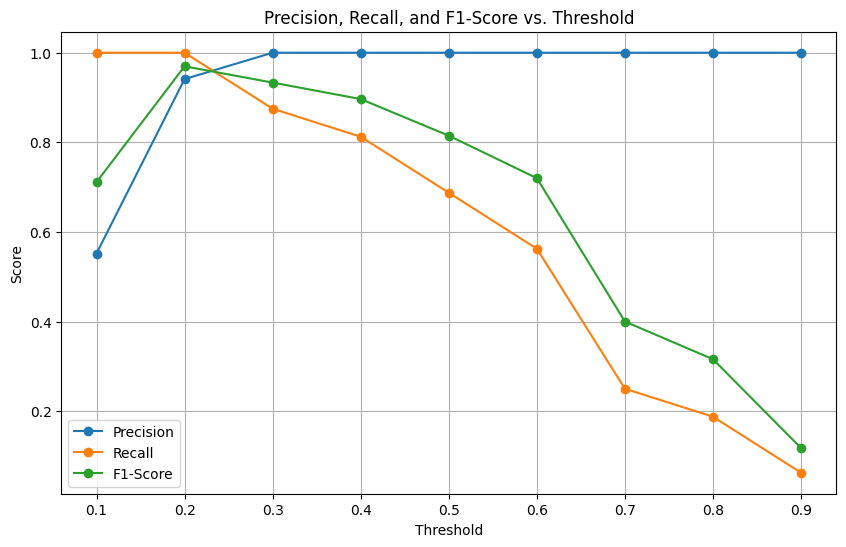

In [9]:
import matplotlib.pyplot as plt

# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label="Precision", marker="o")
plt.plot(thresholds, recall_scores, label="Recall", marker="o")
plt.plot(thresholds, f1_scores, label="F1-Score", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()


## Choose the Optimal Threshold

Based on the results, we choose a threshold that maximizes recall while keeping precision and F1-score at acceptable levels. 
For example, a threshold of 0.2.
The optimal threshold depends on the business context. For example, if missing a Warning Letter or NCR is costly, prioritize recall over precision.

In [18]:
# Set the chosen threshold (e.g., 0.3)
chosen_threshold = 0.2

# Convert probabilities to binary predictions using the chosen threshold
y_pred_final = (y_pred_proba >= chosen_threshold).astype(int)

# Evaluate the final model with the chosen threshold
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Final Model Metrics with Threshold {chosen_threshold}:")
print(f"Precision: {final_precision:.2f}")
print(f"Recall: {final_recall:.2f}")
print(f"F1-Score: {final_f1:.2f}")
print(f"Accuracy: {final_accuracy:.2f}")


Final Model Metrics with Threshold 0.2:
Precision: 0.17
Recall: 0.31
F1-Score: 0.22
Accuracy: 0.81


# Hyperparameter tunning

 Randomized Search vs. Grid Search:

    Use Randomized Search for large hyperparameter spaces to save time.
    Use Grid Search for smaller, well-defined hyperparameter spaces to ensure optimal results.



In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the hyperparameter space
param_distributions = {
    "n_estimators": [50, 100, 200, 300, 400],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring="recall",  # Optimize for recall
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Fit the Randomized Search to the data
random_search.fit(X, y)

# Display the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X)
print("\nClassification Report:")
print(classification_report(y, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1002
           1       0.91      0.90      0.90       138

    accuracy                           0.98      1140
   macro avg       0.95      0.94      0.94      1140
weighted avg       0.98      0.98      0.98      1140

[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimator